In [278]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os
from scipy.fft import dct,idct
from math import log10

In [279]:
def getImageComponents(inputImage):
    os.makedirs("Image Components", exist_ok=True)
    colors = ["Reds","Greens","Blues"]
    for i in range(3):
        plt.figure(figsize=(14, 6))
        plt.imshow(inputImage[:,:,2-i],cmap=colors[i])
        plt.axis("off")
        plt.colorbar()
        plt.savefig(f"Image Components/a_{colors[i][:-1].lower()}.png")

In [280]:
def DCT(processedBlock):
    return dct(dct(processedBlock.T, norm='ortho').T, norm='ortho')
def IDCT(processedBlock):
    return idct(idct(processedBlock.T, norm='ortho').T, norm='ortho')

In [281]:
def compressImage(inputImage,m):
    blocksShape = (inputImage.shape[0]//8,inputImage.shape[1]//8)
    compressedImage = np.zeros((m*blocksShape[0],m*blocksShape[1],3))
    for channel in range(3):
        for row in range(blocksShape[0]):
            for col in range(blocksShape[1]):
                processedBlock = inputImage[8*row:8*(row+1),8*col:8*(col+1),channel]
                dctBlock = DCT(processedBlock)
                dctRetainedBlock = dctBlock[:m,:m]
                compressedImage[m*row:m*(row+1),m*col:m*(col+1),channel] = dctRetainedBlock
    return compressedImage

In [282]:
def decompressImage(compressedImage,m):
    blocksShape = (compressedImage.shape[0]//m,compressedImage.shape[1]//m)
    decompressedImage = np.zeros((8*blocksShape[0],8*blocksShape[1],3))
    for channel in range(3):
        for row in range(blocksShape[0]):
            for col in range(blocksShape[1]):
                processedBlock = np.zeros((8,8))
                processedBlock[:m,:m] = compressedImage[m*row:m*(row+1),m*col:m*(col+1),channel]
                idctBlock = IDCT(processedBlock)
                decompressedImage[8*row:8*(row+1),8*col:8*(col+1),channel] = idctBlock
    return decompressedImage

In [283]:
def calculatePSNR(inputImage,decompressedImage):
    SE = (inputImage-decompressedImage)**2
    MSE = np.mean(SE)
    peak = 255
    PSNR = 10*log10(peak**2/MSE)
    return PSNR

In [284]:
def writeImageInfo(file,sizeInBytes,inputImage,decompressedImage,m):
    file.write(f"\n                 -------------------------------------------For m = {m}-------------------------------------------------\n\n")
    file.write(f"\t\t\t\t\t\tCompressed Image Size : {sizeInBytes/(1024)**2:.2f} MB\n")
    PSNR = calculatePSNR(inputImage,decompressedImage)
    file.write(f"\t\t\t\t\t\tPSNR : {PSNR:.2f} dB\n\n")
    file.write("                 -----------------------------------------------------------------------------------------------------\n\n")
    return PSNR

In [285]:
def plotPSNRS(allMs,PSNRS):
    plt.figure(figsize=(14, 6))
    plt.plot(allMs,PSNRS,marker='o')
    plt.xlabel("m")
    plt.ylabel("PSNR")
    plt.savefig("PSNR_plot.png")

In [286]:
def Project():    
    with open('sizes.txt', 'w') as file:
        # Write to the file
        inputImageArray = cv2.imread("image1.png")
        getImageComponents(inputImageArray)
        os.makedirs("Decompressed Images", exist_ok=True)
        os.makedirs("Compressed Images", exist_ok=True)
        file.write(f"Original Image Size : {sys.getsizeof(inputImageArray)/(1024**2):.2f} MB\n")
        PSNRS = np.zeros(4)
        for m in range(1,5):
            compressedImage = compressImage(inputImageArray,m)
            np.save(f"Compressed Images/compressedImage_m{m}",compressedImage)
            decompressedImage = decompressImage(compressedImage,m)
            PSNR = writeImageInfo(file,sys.getsizeof(compressedImage.astype(np.float16)),inputImageArray,decompressedImage.astype(np.uint8),m)
            PSNRS[m-1]=PSNR
            cv2.imwrite(f"Decompressed Images/decompressedImage_m{m}.png",decompressedImage)
        allMs = np.linspace(1,4,4,dtype=np.uint8)
        plotPSNRS(allMs,PSNRS)

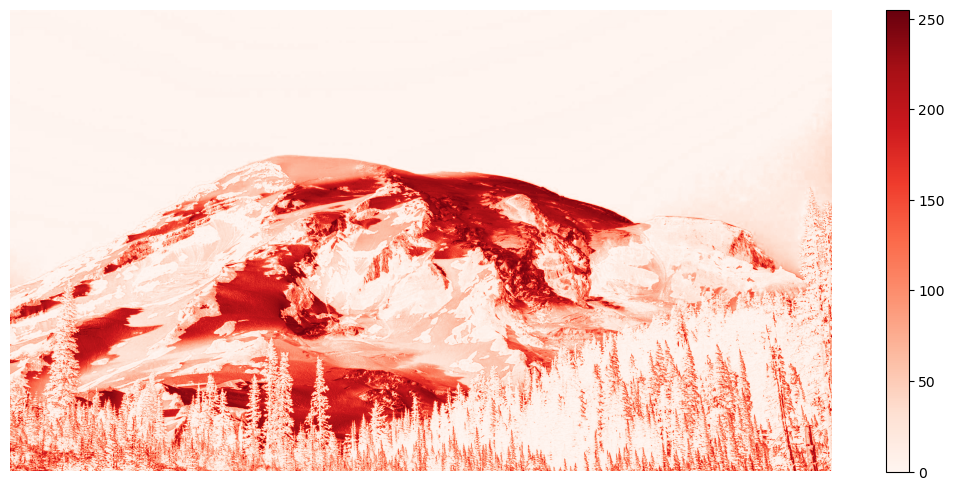

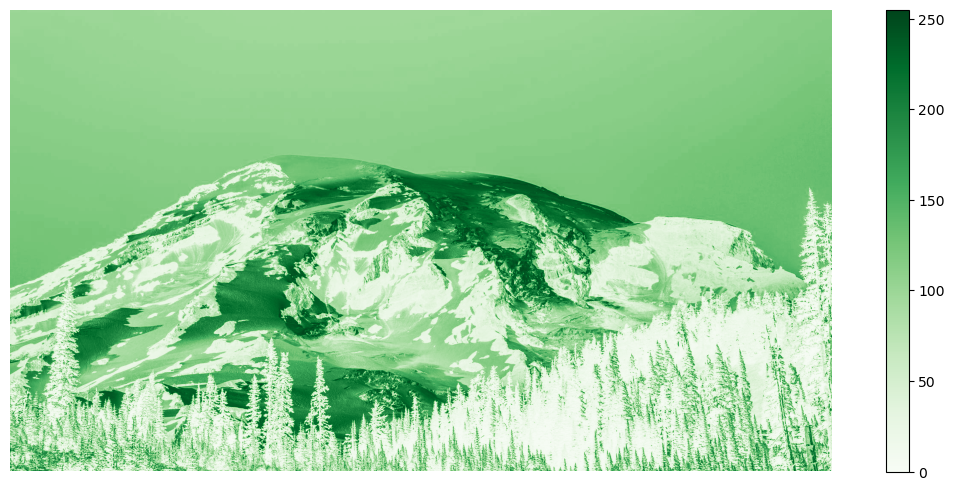

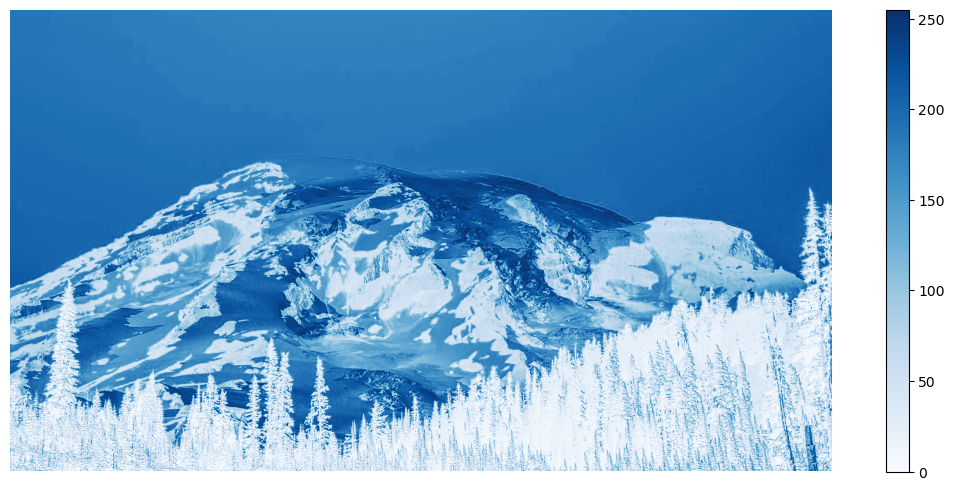

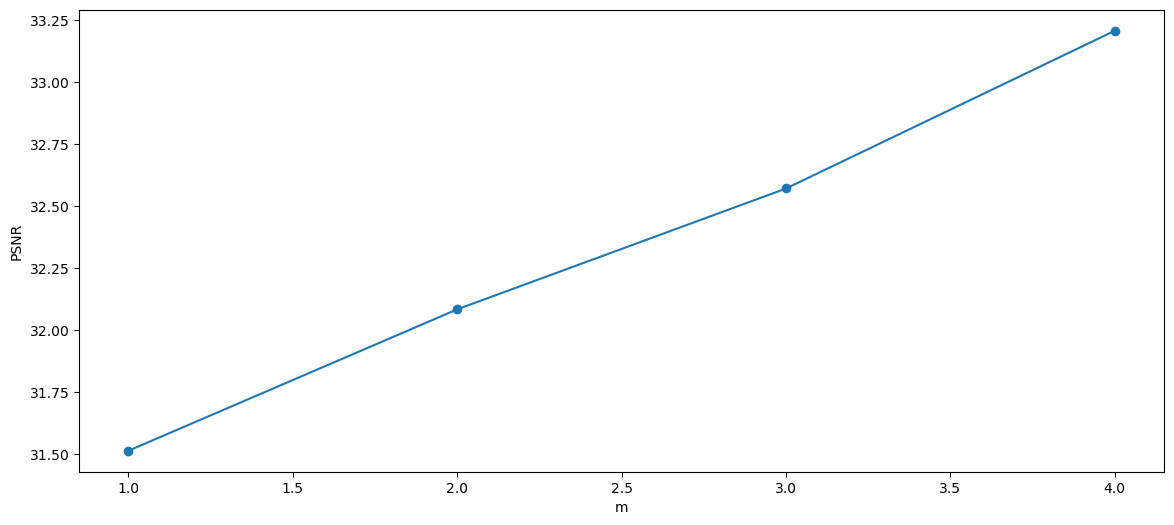

In [287]:
Project()